# DTU 46500 :  Assignment 1
## Statistical extrapolation for Extreme Winds    (2022)
#### Fitting extreme distributions, uncertainty in fitting (including sample-length)
> python note: A very convenient method to work with tabular data is the dataframes made available by the pandas package. However, in this particular exercise we don't specifically need dataframes as the amount of work on tabular data is limited to the filtering part. 
For simplicity we will wait with introducing the dataframes to a future exercise, and we will work with numpy arrays.

In [1]:
####################################
# Special code for Jupyter Notebook
####################################
# Show plots in the notebook
%matplotlib inline 

# Automatically reload any packages that changed
%load_ext autoreload
%autoreload 2

# Display multiple arguments
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import datetime
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
Data = np.genfromtxt('Hovsore2004to2020_U+dir.csv',delimiter=',')
Dnames = ['Timestamp','Wsp','MeanDir']

In [4]:
# CREATE A DATETIME ARRAY SO WE CAN USE ∆T for removing bad data
T = np.empty(Data[:,0].shape, dtype = datetime.datetime) # Empty numpy array of type datetime
for i in range(len(Data[:,0])):
    T[i] = datetime.datetime.strptime(str(Data[i,0].astype('int64')),'%Y%m%d%H%M')
DeltaT = np.diff(T)

Insert reasonable values for minimum U to consider, maximum reasonable U (i.e. to avoid instrumental/data errors), and maximum acceptable jump in 10-minute mean windspeed from one record to the next: 

In [5]:
LowestWindSpeed =5.
CrazyWind =60.
maxDeltaU10min = 10.

In [6]:
# CREATE data-selection "masks" (by using Boolean T/F arrays)

WspOK = ((Data[:,1] > LowestWindSpeed)&(Data[:,1] < CrazyWind)) # Boolean (T or F): reject unrealistic wind speeds

DeltaU = np.diff(Data[:,1])
dU10min = np.empty(DeltaU.shape,dtype = 'float')
for i in range(len(DeltaU)):
    dU10min[i] = DeltaU[i]/(DeltaT[i].seconds/600) 
DeltaUOK = (DeltaU > -maxDeltaU10min) & (DeltaU < maxDeltaU10min) 

OK1 = (WspOK[0:-1]==True) & (DeltaUOK == True)
OK2 = (WspOK[1:]==True) & (DeltaUOK == True)
OK1 = np.append(OK1,True)
OK2 = np.insert(OK2,0,True)

DataOK = OK1 & OK2 # Final filter in terms of a Boolean array

In [7]:
# APPLY FILTERS AND COMPUTE YEAR/MONTH VALUES 

T = T[DataOK]
Timestamp = Data[DataOK,0]
Wsp = Data[DataOK,1]
wdir = Data[DataOK,2]

# Compute year and month
Year = np.floor(Timestamp/1e8).astype('int64')
Month = np.floor(np.mod(Timestamp,1e8)/1e6).astype('int64')
#Day = np.floor(np.mod(Timestamp,1e6)/1e4).astype('int64')
#Hour = np.floor(np.mod(Timestamp,1e4)/1e2).astype('int64')
#Minute = np.floor(np.mod(Timestamp,1e2)/1).astype('int64')

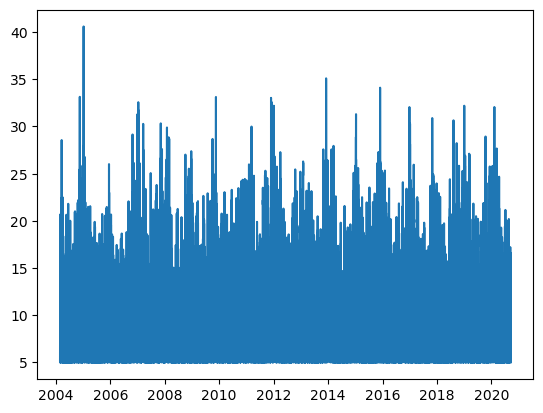

In [8]:
# plot the filtered data to check it:
plt.plot(T,Wsp)
plt.show()

In [9]:
# COMPUTE ANNUAL MAXIMA

Years = np.unique(Year)
nyears = np.max(Years) - np.min(Years)

Umax = np.empty(nyears,dtype = 'float')
## since data starts in October, make each "year" start then
for i in range(nyears):
    CurrentPeriod = ((Year==Years[i]) & (Month >= 10)) | ((Year == (Years[i]+1)) & (Month < 10))
    Umax[i] = max(Wsp[CurrentPeriod])
    

# [1a]
### GUMBEL FIT - METHOD OF Probability-weighted moments (PWM)
Use the formulae from class to compute $\alpha$ and $\beta$ from $b_0$ and $b_1$ using PWM. 

Then use $\{\alpha,\beta\}$ to get $V_{50}$. 

You'll do this a number of times; 
- first, based on the whole dataset, 
- then again, using 2-year non-overlapping segments you'll find 7 "two-year" values of $\{\alpha,\beta,V_{50}\}$. 

The framework for code below helps you start out.

You'll also need to **answer quantitatively: "how well does this follow a Gumbel distribution!?" for both cases.**  
Try to quantify the variation of using only 2-year periods; how does this compare to theoretical expectation? 

In [10]:
UmaxSorted = np.sort(Umax)

In [11]:
b0PWM = 

SyntaxError: invalid syntax (1757618604.py, line 1)

In [ ]:
b1PWM = 

In [ ]:
alphaPWM = 

In [ ]:
betaPWM = 

In [ ]:
V50PWM = 

In [ ]:
print('PWM: V50= '+str(V50PWM.round(1))+' m/s; alpha='+str(alphaPWM.round(2))+', beta='+str(betaPWM.round(1))+' m/s')

### GUMBEL FIT - V50 from another method
Now use another method (of your choice) to calculate $V_{50}$ (e.g. max-likelihood, ACER, etc.). <br>
How well does this fit the Gumbel PDF (or CDF)?

# 1b: Uncertainty in $V_{50}$ estimates
Using the $\alpha$-parameter you found above in [1a] using _the whole 16-year timeseries_, 
- do bootstrap sampling with many 2-year segments to get a distribution of $f_{2y}(\alpha$ and $f_{2y}(V_{50})$; 
     - what is the uncertainty in using 2-year segments, i.e., the standard deviation $\sigma_{V50_\textrm{fit 2yr}}$
- repeat this for other segment lengths (3 years, 4y...10y), to get (fit) a relation for $\sigma^2_{V50}(T_\textrm{segment})$
- How does your relation for $\sigma^2_{V50}(T_\textrm{segment})$ compare to the Ott(2011) expression for $\sigma^2_{U_T}$? 
    - ignoring $\beta$, how much variation in $\alpha$ (e.g. $\sigma_\alpha/\langle\alpha\rangle$) does your $\sigma^2_{V50}(T_\textrm{segment})$ correspond to? 

In [12]:
def Vgumbel(alpha, beta, T, T0=1):
    """
    Parameters
    ----------
    alpha : 1st Gumbel parameter.
    beta : 2nd Gumbel parameter.
    T : return period.
    T0 : base period. The default is 1.

    Returns
    -------
    extreme wind speed.

    """
    return beta - alpha * np.log(np.log(1 / (1- T0/T)))


Bootstrap sampling with many 2-year segments

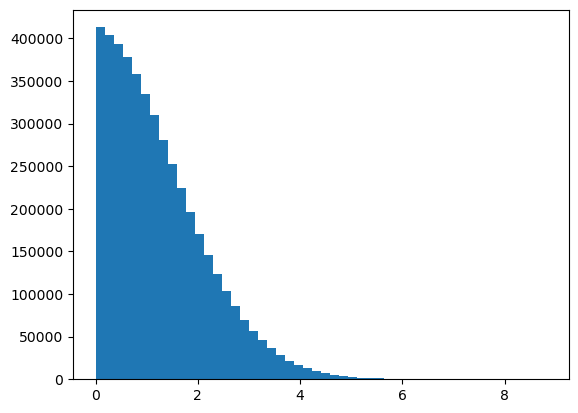

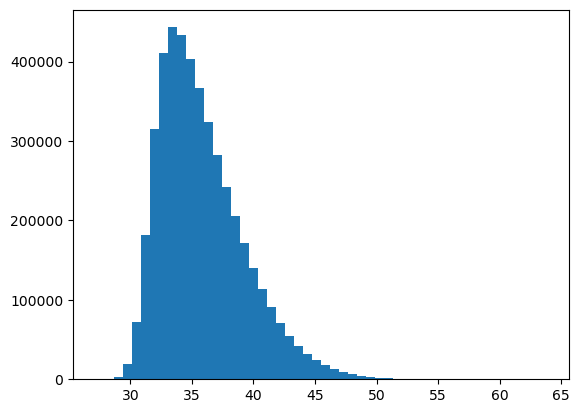

3.44582332387128

7.6336353048477354
3.9791734893920814


In [17]:
Nbs = 9000000 #Nbootstrap\n",
Sbs = 5 #the more the size, the less the STD, Bootstrapsize\n",

alpha = 2.798
Eulerconst = 0.577
T0=1
T50=50

#for ba in range(len(Sbs))
BS = np.random.choice(Umax,size = (Nbs,Sbs)) #as many columns Sbs and lines as Nbs
Ubs_mean = BS.mean(axis = 1) #Umean from wind maxima for columns Sbs and one line  


# we reshape the Ubs_mean matrix 
Ubs_mean_reshaped = Ubs_mean.reshape(-1,2)  #reshaped for 2 years


n = Ubs_mean_reshaped.shape[-1] #yields the number of bootstrap sets

# rank the yearly maxima (along last axis) # proceed as before
UmaxSorted = np.sort(Ubs_mean_reshaped)

# compute moments
b0 = np.sum(Ubs_mean_reshaped, -1)/n
b1 = np.sum(np.multiply(np.arange(0, n), UmaxSorted), -1) / n / (n-1)
    
alpha_2 = (2*b1 - b0) / np.log(2)
beta = b0 - Eulerconst * alpha_2

Vxtr = Vgumbel(alpha_2, beta, T50, T0=T0)
alpha_plot =  plt.hist(alpha_2, 50)
plt.show()

Vxtr_plot =  plt.hist(Vxtr, 50)
plt.show()


#std for uncertainty
Vxtr_std_2 = np.std(Vxtr)
Vxtr_std_2

#uncertainty
kf = (np.sqrt(6)/np.pi)*(np.log(50/Sbs)-Eulerconst)
VarUt = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+1.14*kf+1.1*kf**2)
C_2 = np.sqrt(VarUt*(Sbs))
print(C_2)

#Comparing to the Monte-Carlo
qt = (np.log(50/Sbs)-Eulerconst)/np.log(2)
#MC_Var_Ut = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+0.584*qt+(0.234*qt**2)/(1-(0.823/(Sbs))))
#MC_conv_2 = np.sqrt(MC_Var_Ut*(Sbs))
MC_Var_Ut = ((alpha**2*np.pi**2)/(6*(n)))*(1+0.584*qt+(0.234*qt**2)/(1-(0.823/(n))))
MC_conv_2 = np.sqrt(MC_Var_Ut/(n))
print(MC_conv_2)





In [16]:
MC_Var_Ut

31.667643317361502

Bootstrap sampling with many 3-year segments

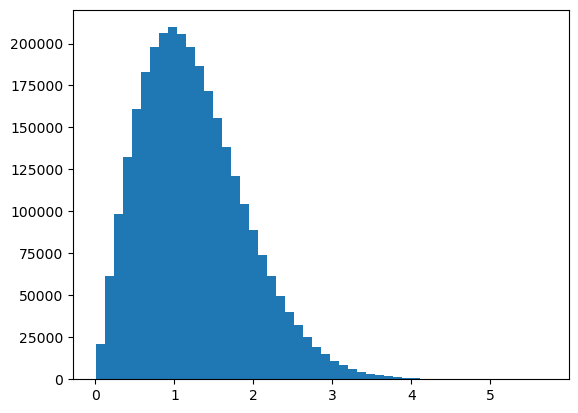

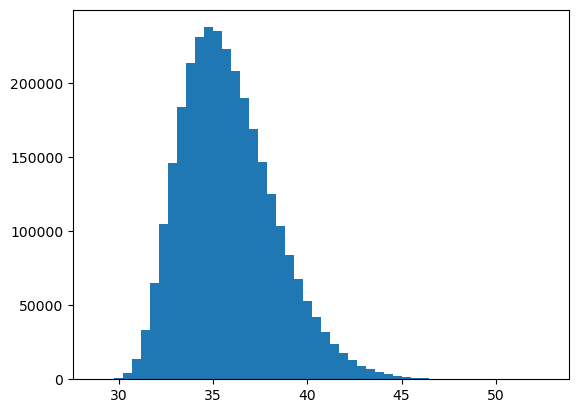

2.479423993433654

7.6336353048477354

7.345486624231335

In [21]:
Nbs = 9000000 #Nbootstrap\n",
Sbs = 5 #the more the size, the less the STD, Bootstrapsize\n",

alpha = 2.798
Eulerconst = 0.577
T0=1
T50=50

#for ba in range(len(Sbs))
BS = np.random.choice(Umax,size = (Nbs,Sbs)) #as many columns Sbs and lines as Nbs
Ubs_mean = BS.mean(axis = 1) #Umean from wind maxima for columns Sbs and one line  


# we reshape the Ubs_mean matrix 
Ubs_mean_reshaped = Ubs_mean.reshape(-1,3)  #reshaped for 3 years


n = Ubs_mean_reshaped.shape[-1]

# rank the yearly maxima (along last axis)
UmaxSorted = np.sort(Ubs_mean_reshaped)

# compute moments
b0 = np.sum(Ubs_mean_reshaped, -1)/n
b1 = np.sum(np.multiply(np.arange(0, n), UmaxSorted), -1) / n / (n-1)
    
alpha_2 = (2*b1 - b0) / np.log(2)
beta = b0 - Eulerconst * alpha_2

Vxtr = Vgumbel(alpha_2, beta, T50, T0=T0)
alpha_plot =  plt.hist(alpha_2, 50)
plt.show()

Vxtr_plot =  plt.hist(Vxtr, 50)
plt.show()


#std for uncertainty
Vxtr_std_3 = np.std(Vxtr)
Vxtr_std_3

#uncertainty
kf = (np.sqrt(6)/np.pi)*(np.log(50/Sbs)-Eulerconst)
VarUt = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+1.14*kf+1.1*kf**2)
C_3 = np.sqrt(VarUt*(Sbs))
C_3

#Comparing to the Monte-Carlo
qt = (np.log(50/Sbs)-Eulerconst)/np.log(2)
MC_Var_Ut = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+0.584*qt+(0.234*qt**2)/(1-(0.823/(Sbs))))
MC_conv_3 = np.sqrt(MC_Var_Ut*(Sbs))
MC_conv_3


Bootstrap sampling with many 4-year segments

In [ ]:
Nbs = 9000000 #Nbootstrap\n",
Sbs = 5 #the more the size, the less the STD, Bootstrapsize\n",

alpha = 2.798
Eulerconst = 0.577
T0=1
T50=50

#for ba in range(len(Sbs))
BS = np.random.choice(Umax,size = (Nbs,Sbs)) #as many columns Sbs and lines as Nbs
Ubs_mean = BS.mean(axis = 1) #Umean from wind maxima for columns Sbs and one line  


# we reshape the Ubs_mean matrix 
Ubs_mean_reshaped = Ubs_mean.reshape(-1,4)  #reshaped for 4 years


n = Ubs_mean_reshaped.shape[-1]

# rank the yearly maxima (along last axis)
UmaxSorted = np.sort(Ubs_mean_reshaped)

# compute moments
b0 = np.sum(Ubs_mean_reshaped, -1)/n
b1 = np.sum(np.multiply(np.arange(0, n), UmaxSorted), -1) / n / (n-1)
    
alpha_2 = (2*b1 - b0) / np.log(2)
beta = b0 - Eulerconst * alpha_2

Vxtr = Vgumbel(alpha_2, beta, T50, T0=T0)
alpha_plot =  plt.hist(alpha_2, 50)
plt.show()

Vxtr_plot =  plt.hist(Vxtr, 50)
plt.show()


#std for uncertainty
Vxtr_std_4 = np.std(Vxtr)
Vxtr_std_4

#uncertainty
kf = (np.sqrt(6)/np.pi)*(np.log(50/Sbs)-Eulerconst)
VarUt = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+1.14*kf+1.1*kf**2)
C_4 = np.sqrt(VarUt*(Sbs))
C_4

#Comparing to the Monte-Carlo
qt = (np.log(50/Sbs)-Eulerconst)/np.log(2)
MC_Var_Ut = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+0.584*qt+(0.234*qt**2)/(1-(0.823/(Sbs))))
MC_conv_4 = np.sqrt(MC_Var_Ut*(Sbs))
MC_conv_4

Bootstrap sampling with many 5-year segments

In [ ]:
Nbs = 9000000 #Nbootstrap\n",
Sbs = 5 #the more the size, the less the STD, Bootstrapsize\n",

alpha = 2.798
Eulerconst = 0.577
T0=1
T50=50

#for ba in range(len(Sbs))
BS = np.random.choice(Umax,size = (Nbs,Sbs)) #as many columns Sbs and lines as Nbs
Ubs_mean = BS.mean(axis = 1) #Umean from wind maxima for columns Sbs and one line  


# we reshape the Ubs_mean matrix 
Ubs_mean_reshaped = Ubs_mean.reshape(-1,5)  #reshaped for 5 years


n = Ubs_mean_reshaped.shape[-1]

# rank the yearly maxima (along last axis)
UmaxSorted = np.sort(Ubs_mean_reshaped)

# compute moments
b0 = np.sum(Ubs_mean_reshaped, -1)/n
b1 = np.sum(np.multiply(np.arange(0, n), UmaxSorted), -1) / n / (n-1)
    
alpha_2 = (2*b1 - b0) / np.log(2)
beta = b0 - Eulerconst * alpha_2

Vxtr = Vgumbel(alpha_2, beta, T50, T0=T0)
alpha_plot =  plt.hist(alpha_2, 50)
plt.show()

Vxtr_plot =  plt.hist(Vxtr, 50)
plt.show()


#std for uncertainty
Vxtr_std_5 = np.std(Vxtr)
Vxtr_std_5

#uncertainty
kf = (np.sqrt(6)/np.pi)*(np.log(50/Sbs)-Eulerconst)
VarUt = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+1.14*kf+1.1*kf**2)
C_5 = np.sqrt(VarUt*(Sbs))
C_5

#Comparing to the Monte-Carlo
qt = (np.log(50/Sbs)-Eulerconst)/np.log(2)
MC_Var_Ut = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+0.584*qt+(0.234*qt**2)/(1-(0.823/(Sbs))))
MC_conv_5 = np.sqrt(MC_Var_Ut*(Sbs))
MC_conv_5

Bootstrap sampling with many 6-year segments

In [1]:
Nbs = 7000000 #Nbootstrap\n",
Sbs = 5 #the more the size, the less the STD, Bootstrapsize\n",

alpha = 2.798
Eulerconst = 0.577
T0=1
T50=50

#for ba in range(len(Sbs))
BS = np.random.choice(Umax,size = (Nbs,Sbs)) #as many columns Sbs and lines as Nbs
Ubs_mean = BS.mean(axis = 1) #Umean from wind maxima for columns Sbs and one line  


# we reshape the Ubs_mean matrix 
Ubs_mean_reshaped = Ubs_mean.reshape(-1,7)  #reshaped for 6 years


n = Ubs_mean_reshaped.shape[-1]

# rank the yearly maxima (along last axis)
UmaxSorted = np.sort(Ubs_mean_reshaped)

# compute moments
b0 = np.sum(Ubs_mean_reshaped, -1)/n
b1 = np.sum(np.multiply(np.arange(0, n), UmaxSorted), -1) / n / (n-1)
    
alpha_2 = (2*b1 - b0) / np.log(2)
beta = b0 - Eulerconst * alpha_2

Vxtr = Vgumbel(alpha_2, beta, T50, T0=T0)
alpha_plot =  plt.hist(alpha_2, 50)
plt.show()

Vxtr_plot =  plt.hist(Vxtr, 50)
plt.show()


#std for uncertainty
Vxtr_std_6 = np.std(Vxtr)
Vxtr_std_6

#uncertainty
kf = (np.sqrt(6)/np.pi)*(np.log(50/Sbs)-Eulerconst)
VarUt = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+1.14*kf+1.1*kf**2)
C_6 = np.sqrt(VarUt*(Sbs))
C_6

#Comparing to the Monte-Carlo
qt = (np.log(50/Sbs)-Eulerconst)/np.log(2)
MC_Var_Ut = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+0.584*qt+(0.234*qt**2)/(1-(0.823/(Sbs))))
MC_conv_6 = np.sqrt(MC_Var_Ut*(Sbs))
MC_conv_6

NameError: name 'np' is not defined

Bootstrap sampling with many 8-year segments

In [15]:
Nbs = 8000000 #Nbootstrap\n",
Sbs = 5 #the more the size, the less the STD, Bootstrapsize\n",

alpha = 2.798
Eulerconst = 0.577
T0=1
T50=50

#for ba in range(len(Sbs))
BS = np.random.choice(Umax,size = (Nbs,Sbs)) #as many columns Sbs and lines as Nbs
Ubs_mean = BS.mean(axis = 1) #Umean from wind maxima for columns Sbs and one line  


# we reshape the Ubs_mean matrix 
Ubs_mean_reshaped = Ubs_mean.reshape(-1,8)  #reshaped for 7 years


n = Ubs_mean_reshaped.shape[-1]

# rank the yearly maxima (along last axis)
UmaxSorted = np.sort(Ubs_mean_reshaped)

# compute moments
b0 = np.sum(Ubs_mean_reshaped, -1)/n
b1 = np.sum(np.multiply(np.arange(0, n), UmaxSorted), -1) / n / (n-1)
    
alpha_2 = (2*b1 - b0) / np.log(2)
beta = b0 - Eulerconst * alpha_2

Vxtr = Vgumbel(alpha_2, beta, T50, T0=T0)
alpha_plot =  plt.hist(alpha_2, 50)
plt.show()

Vxtr_plot =  plt.hist(Vxtr, 50)
plt.show()


#std for uncertainty
Vxtr_std_7 = np.std(Vxtr)
Vxtr_std_7

#uncertainty
kf = (np.sqrt(6)/np.pi)*(np.log(50/Sbs)-Eulerconst)
VarUt = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+1.14*kf+1.1*kf**2)
C_7 = np.sqrt(VarUt*(Sbs))
C_7

#Comparing to the Monte-Carlo
qt = (np.log(50/Sbs)-Eulerconst)/np.log(2)
MC_Var_Ut = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+0.584*qt+(0.234*qt**2)/(1-(0.823/(Sbs))))
MC_conv_7 = np.sqrt(MC_Var_Ut*(Sbs))
MC_conv_7

NameError: name 'Vgumbel' is not defined

Bootstrap sampling with many 9-year segments

In [16]:
Nbs = 9000000 #Nbootstrap\n",
Sbs = 5 #the more the size, the less the STD, Bootstrapsize\n",

alpha = 2.798
Eulerconst = 0.577
T0=1
T50=50

#for ba in range(len(Sbs))
BS = np.random.choice(Umax,size = (Nbs,Sbs)) #as many columns Sbs and lines as Nbs
Ubs_mean = BS.mean(axis = 1) #Umean from wind maxima for columns Sbs and one line  


# we reshape the Ubs_mean matrix 
Ubs_mean_reshaped = Ubs_mean.reshape(-1,9)  #reshaped for 8 years


n = Ubs_mean_reshaped.shape[-1]

# rank the yearly maxima (along last axis)
UmaxSorted = np.sort(Ubs_mean_reshaped)

# compute moments
b0 = np.sum(Ubs_mean_reshaped, -1)/n
b1 = np.sum(np.multiply(np.arange(0, n), UmaxSorted), -1) / n / (n-1)
    
alpha_2 = (2*b1 - b0) / np.log(2)
beta = b0 - Eulerconst * alpha_2

Vxtr = Vgumbel(alpha_2, beta, T50, T0=T0)
alpha_plot =  plt.hist(alpha_2, 50)
plt.show()

Vxtr_plot =  plt.hist(Vxtr, 50)
plt.show()


#std for uncertainty
Vxtr_std_8 = np.std(Vxtr)
Vxtr_std_8

#uncertainty
kf = (np.sqrt(6)/np.pi)*(np.log(50/Sbs)-Eulerconst)
VarUt = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+1.14*kf+1.1*kf**2)
C_8 = np.sqrt(VarUt*(Sbs))
C_8

#Comparing to the Monte-Carlo
qt = (np.log(50/Sbs)-Eulerconst)/np.log(2)
MC_Var_Ut = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+0.584*qt+(0.234*qt**2)/(1-(0.823/(Sbs))))
MC_conv_8 = np.sqrt(MC_Var_Ut*(Sbs))
MC_conv_8

NameError: name 'Vgumbel' is not defined

Bootstrap sampling with many 10-year segments

In [17]:
Nbs = 10000000 #Nbootstrap\n",
Sbs = 5 #the more the size, the less the STD, Bootstrapsize\n",

alpha = 2.798
Eulerconst = 0.577
T0=1
T50=50

#for ba in range(len(Sbs))
BS = np.random.choice(Umax,size = (Nbs,Sbs)) #as many columns Sbs and lines as Nbs
Ubs_mean = BS.mean(axis = 1) #Umean from wind maxima for columns Sbs and one line  


# we reshape the Ubs_mean matrix 
Ubs_mean_reshaped = Ubs_mean.reshape(-1,10)  #reshaped for 9 years


n = Ubs_mean_reshaped.shape[-1]

# rank the yearly maxima (along last axis)
UmaxSorted = np.sort(Ubs_mean_reshaped)

# compute moments
b0 = np.sum(Ubs_mean_reshaped, -1)/n
b1 = np.sum(np.multiply(np.arange(0, n), UmaxSorted), -1) / n / (n-1)
    
alpha_2 = (2*b1 - b0) / np.log(2)
beta = b0 - Eulerconst * alpha_2

Vxtr = Vgumbel(alpha_2, beta, T50, T0=T0)
alpha_plot =  plt.hist(alpha_2, 50)
plt.show()

Vxtr_plot =  plt.hist(Vxtr, 50)
plt.show()


#std for uncertainty
Vxtr_std_9 = np.std(Vxtr)
Vxtr_std_9

#uncertainty
kf = (np.sqrt(6)/np.pi)*(np.log(50/Sbs)-Eulerconst)
VarUt = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+1.14*kf+1.1*kf**2)
C_9 = np.sqrt(VarUt*(Sbs))
C_9

#Comparing to the Monte-Carlo
qt = (np.log(50/Sbs)-Eulerconst)/np.log(2)
MC_Var_Ut = ((alpha**2*np.pi**2)/(6*(Sbs)))*(1+0.584*qt+(0.234*qt**2)/(1-(0.823/(Sbs))))
MC_conv_9 = np.sqrt(MC_Var_Ut*(Sbs))
MC_conv_9

NameError: name 'Vgumbel' is not defined

In [18]:
years=[2,3,4,5,6,7,8,9]
Vxtr_std=[Vxtr_std_2,Vxtr_std_3,Vxtr_std_4,Vxtr_std_5,Vxtr_std_6,Vxtr_std_7,Vxtr_std_8,Vxtr_std_9]
C=[C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9]
MC_conv=[MC_conv_2,MC_conv_3,MC_conv_4,MC_conv_5,MC_conv_6,MC_conv_7,MC_conv_8,MC_conv_9]
C
MC_conv


_= plt.figure();
_= plt.plot(years,Vxtr_std);
_= plt.plot(years,C);
_= plt.plot(years,MC_conv);
_= plt.title('Comparisson 3 different Methods');
_= plt.xlabel('Number of Years');
_= plt.ylabel('Standard deviation');
_= plt.legend(['Standard Deviation','Uncertainty Estimate','Monte Carlo']);
plt.show()

NameError: name 'Vxtr_std_2' is not defined